In [5]:
%%capture
import sys
import glob, os
import pyicon as pyic
import smt_modules.all_funcs as eva
from smt_modules.icon_smt_levels import dzw, dzt, depthc, depthi
import smt_modules.tools as tools

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import gsw

from scipy import stats    #Used for 2D binned statistics
from importlib import reload

In [6]:
#Reload modules:
reload(eva)
reload(tools)

Load my smt functions


<module 'smt_modules.tools' from '/home/m/m300878/submesoscaletelescope/smt_modules/tools.py'>

In [2]:
path_data = '/work/mh0033/from_Mistral/mh0033/u241317/smt/forcing/ustressSelL.nc'
ustress = xr.open_dataset(path_data)
lonw = ustress.lon #.data
latw = ustress.lat #.data

path_data = '/work/mh0033/from_Mistral/mh0033/u241317/smt/forcing/vstressSelL.nc'
vstress = xr.open_dataset(path_data)
windstress = np.sqrt(ustress**2 + vstress**2)

In [3]:
rh0 = 1024
fe = 2.* 2.*np.pi/86400. * np.sin(latw*np.pi/180.)
# c_drag = 0.1

In [7]:
lon_reg_all, lat_reg_all = eva.get_fronts()

In [95]:
# tau_x = c_drag * rh0 * xr.ufuncs.square(ustress)
# tau_y = c_drag * rh0 * xr.ufuncs.square(vstress)

In [8]:
dy_tau_x = ustress.differentiate("lat")
dx_tau_y = vstress.differentiate("lon")
wind_stress_curl = -dy_tau_x + dx_tau_y

tau_x_scaled = ustress/rh0/fe
tau_y_scaled = vstress/rh0/fe
dy_tau_x = tau_x_scaled.differentiate("lat")
dx_tau_y = tau_y_scaled.differentiate("lon")
w_ek = -dy_tau_x + dx_tau_y

In [47]:
def add_rectangles():
    fs = 22
    for ii in np.arange(12):
        if ii ==3: continue
        front =           f'R{ii+1}f'
        lon_front = lon_reg_all[ii,:]
        lat_front = lat_reg_all[ii,:]
        rect, right, top = eva.draw_rect(lat_front, lon_front,  color='purple')
        ax.add_patch(rect)
        ax.text(right, top, f'{front}', fontsize=fs)


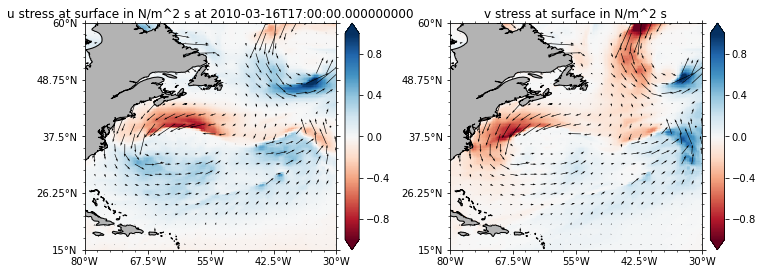

In [104]:
asp = 45/50
t = 20
hca, hcb = pyic.arrange_axes(2, 1, plot_cb=True, asp=asp, fig_size_fac=2, projection=ccrs_proj, axlab_kw=None)
lon = lonw
lat = latw
lon_reg = lon.min(), lon.max()
lat_reg = lat.min(), lat.max()

ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 1
pyic.shade(lon, lat, ustress.isel(time=t).var180, ax=ax, cax=cax,  transform=ccrs_proj, clim=clim, rasterized=False, cmap='RdBu')
ar=8
ax.quiver(lonw[::ar], latw[::ar], ustress.isel(time=t).var180[::ar,::ar], vstress.isel(time=t).var180[::ar,::ar])

ax.set_title(f'u stress at surface in N/m^2 s at {ustress.time[t].data}')

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 1
pyic.shade(lon, lat, vstress.isel(time=t).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu')
ar=8
ax.quiver(lonw[::ar], latw[::ar], ustress.isel(time=t).var180[::ar,::ar], vstress.isel(time=t).var180[::ar,::ar])
ax.set_title(f'v stress at surface in N/m^2 s')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 

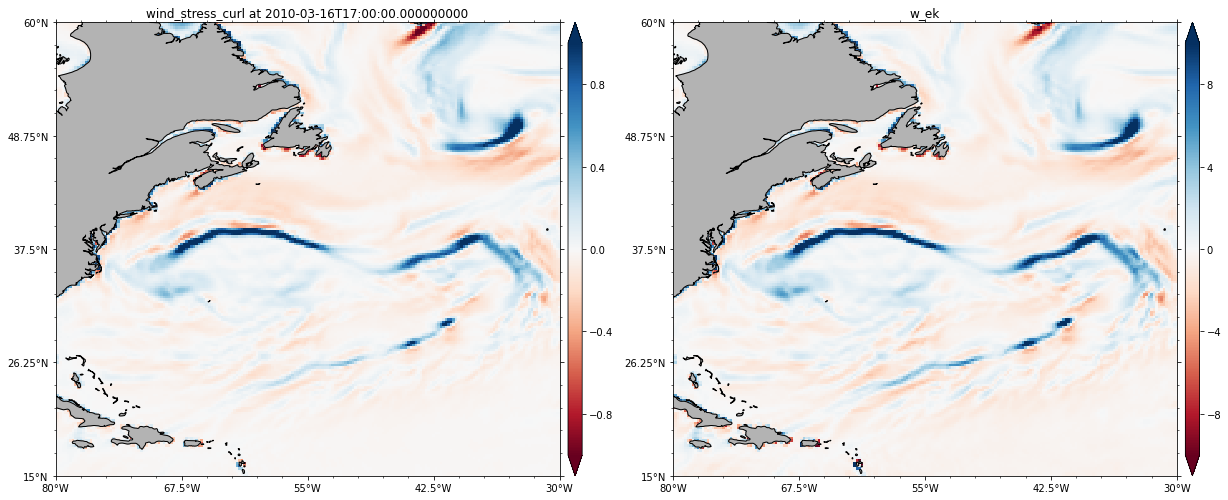

In [103]:
asp = 45/50
t = 20
hca, hcb = pyic.arrange_axes(2, 1, plot_cb=True, asp=asp, fig_size_fac=4, projection=ccrs_proj, axlab_kw=None)
lon = lonw
lat = latw
lon_reg = lon.min(), lon.max()
lat_reg = lat.min(), lat.max()

ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 1
pyic.shade(lon, lat, wind_stress_curl.isel(time=t).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj,  rasterized=False, cmap='RdBu')
ax.set_title(f'wind_stress_curl at {wind_stress_curl.time[t].data}')

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 10
pyic.shade(lon, lat, w_ek.isel(time=t).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu')
ax.set_title(f'w_ek')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 

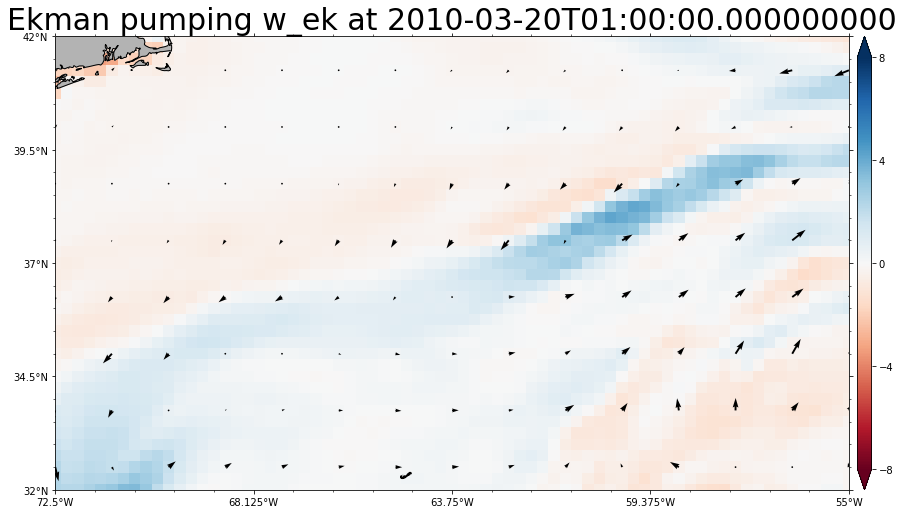

In [119]:
lon = lonw
lat = latw
# lon_reg = lon.min(), lon.max()
# lat_reg = lat.min(), lat.max()
lon_reg = lon_reg_large = [-72.5, -55]
lat_reg = lat_reg_large = [32, 42]
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
t = 100
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=4, projection=ccrs_proj, axlab_kw=None)


ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 8
pyic.shade(lon, lat, w_ek.isel(time=t).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu')
ar=5
ax.quiver(lonw[::ar], latw[::ar], ustress.isel(time=t).var180[::ar,::ar], vstress.isel(time=t).var180[::ar,::ar])

ax.set_title(f'Ekman pumping w_ek at {wind_stress_curl.time[t].data}', fontsize=30)
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 

## time averages

In [12]:
w_ek_week = w_ek.mean(dim='time')
w_ek_week.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
w_ek_week.attrs["time steps"] = "169"

w_ek_day = w_ek.resample(time='1D').mean()
w_ek_day = w_ek_day.isel(time=slice(1,7)) #select only days with 12 mean members
w_ek_day.attrs["time averaged"] = "2010-03-16T01 - 2010-03-21T23"
w_ek_day.attrs["time steps"] = "24 on each day"
w_ek_2d = w_ek_day.resample(time='2D').mean()

In [13]:
ustress_week = ustress.mean(dim='time')
ustress_week.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
ustress_week.attrs["time steps"] = "169"

ustress_day = ustress.resample(time='1D').mean()
ustress_day = ustress_day.isel(time=slice(1,7)) #select only days with 12 mean members
ustress_day.attrs["time averaged"] = "2010-03-16T01 - 2010-03-21T23"
ustress_day.attrs["time steps"] = "24 on each day"
ustress_2d = ustress_day.resample(time='2D').mean()

vstress_week = vstress.mean(dim='time')
vstress_week.attrs["time averaged"] = "2010-03-15T21 - 2010-03-22T21"
vstress_week.attrs["time steps"] = "169"

vstress_day = vstress.resample(time='1D').mean()
vstress_day = vstress_day.isel(time=slice(1,7)) #select only days with 12 mean members
vstress_day.attrs["time averaged"] = "2010-03-16T01 - 2010-03-21T23"
vstress_day.attrs["time steps"] = "24 on each day"
vstress_2d = vstress_day.resample(time='2D').mean()



## old visual

In [14]:
import matplotlib.patches as patches

In [152]:
def draw_rect(lat, lon, color):
    height = lat[1] - lat[0]
    width = lon[1] - lon[0]
    right = lon[0] + width
    top = lat[0] + height
    rect = patches.Rectangle((lon[0], lat[0]), width, height, linewidth=3, edgecolor=color, facecolor='none')
    return  rect, right, top

In [153]:
def add_rect():
    #boxes
    lon_reg_R1 = [-65, -60]
    lat_reg_R1 = [32, 34.5]
    lon_reg_R2 = [-65, -60]
    lat_reg_R2 = [38.75, 41.25]
    lon_reg_R3 = [-65, -60]
    lat_reg_R3 = [35.375, 37.875]
    lon_reg_R4 = [-68, -65.2]
    lat_reg_R4 = [35, 37]
    #fronts
    lon_f1 = -61.25
    lat_f1 =  32.5, 33.5
    
    lon_f2 = -59.39
    lat_f2 =  35.3, 36.1
    
    lon_f3 = -62.35
    lat_f3 =  35.45, 36.15
    
    lon_f4 = -66.1
    lat_f4 =  34.1, 34.75
    fs=25

    ax.vlines(lon_f1, lat_f1[0], lat_f1[1], color='g', linewidth=3)
    ax.text(lon_f1, lat_f1[1], f'F1', fontsize=fs)

    ax.vlines(lon_f2, lat_f2[0], lat_f2[1], color='g', linewidth=3)
    ax.text(lon_f2, lat_f2[1], f'F2', fontsize=fs)

    ax.vlines(lon_f3, lat_f3[0], lat_f3[1], color='g', linewidth=3)
    ax.text(lon_f3, lat_f3[1], f'F3', fontsize=fs)

    ax.vlines(lon_f4, lat_f4[0], lat_f4[1], color='g', linewidth=3)
    ax.text(lon_f4, lat_f4[0], f'F4', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R1, lon_reg_R1,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R1', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R2, lon_reg_R2,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R2', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R3, lon_reg_R3,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R3', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R4, lon_reg_R4,  color='black')
    ax.add_patch(rect)
    ax.text(right-1.7, top, f'R4', fontsize=fs)

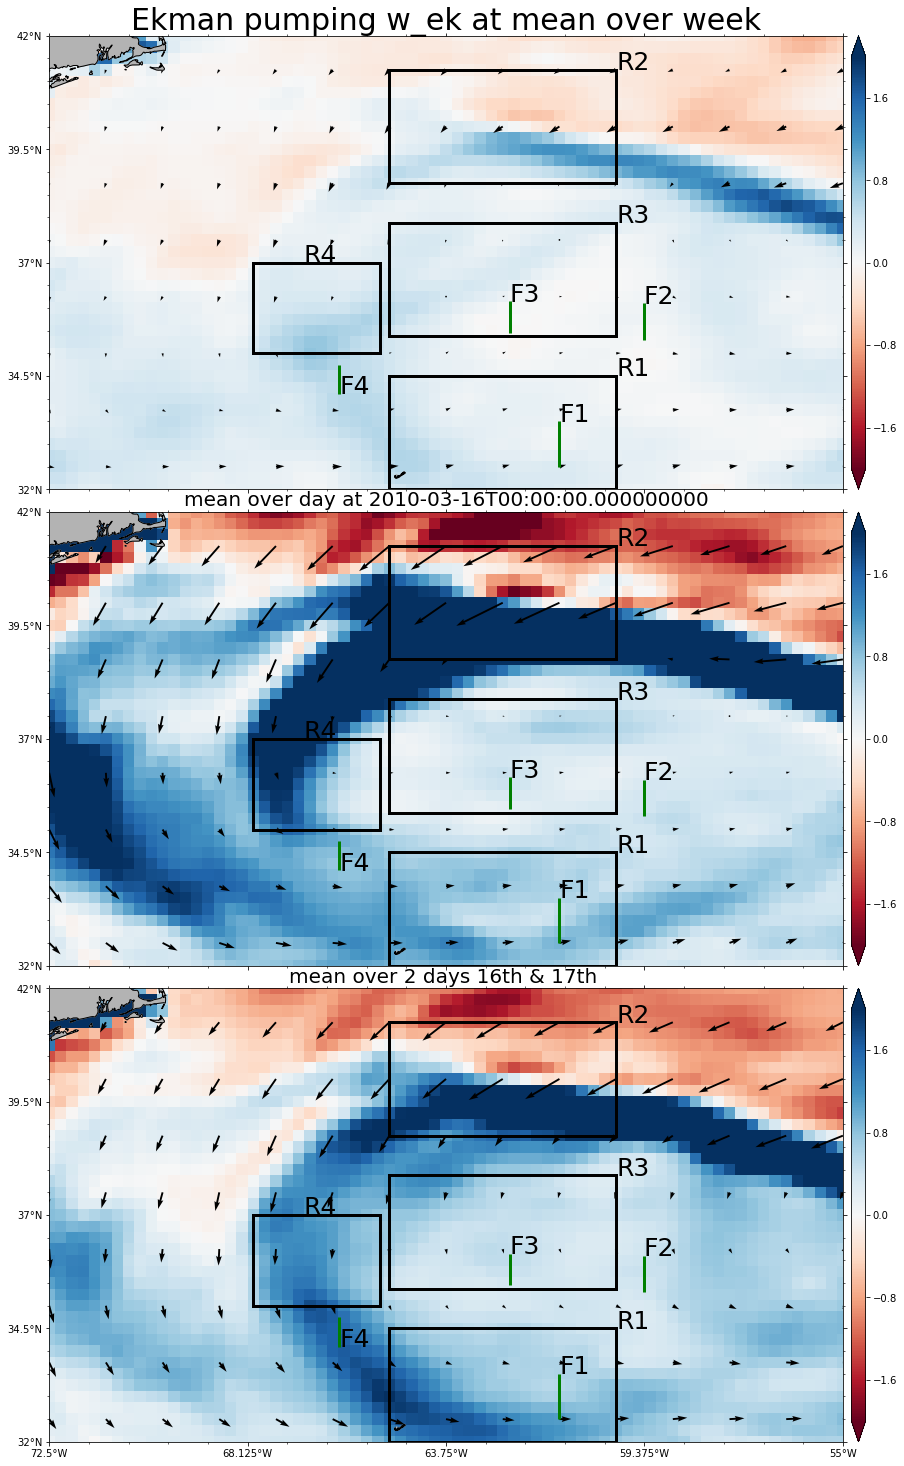

In [163]:
lon = lonw
lat = latw
# lon_reg = lon.min(), lon.max()
# lat_reg = lat.min(), lat.max()
lon_reg = lon_reg_large = [-72.5, -55]
lat_reg = lat_reg_large = [32, 42]
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
t = 0
hca, hcb = pyic.arrange_axes(1, 3, plot_cb=True, asp=asp, fig_size_fac=4, projection=ccrs_proj, sharex=True, axlab_kw=None)

ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 2
pyic.shade(lon, lat, w_ek_week.var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu')
ar=5
ax.quiver(lonw[::ar], latw[::ar], ustress_week.var180[::ar,::ar], vstress_week.var180[::ar,::ar])
add_rect()
ax.set_title(f'Ekman pumping w_ek at mean over week', fontsize=30)

ii+=1; ax=hca[ii]; cax=hcb[ii]

pyic.shade(lon, lat, w_ek_day.isel(time=0).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu')
ar=5
ax.quiver(lonw[::ar], latw[::ar], ustress_day.isel(time=t).var180[::ar,::ar], vstress_day.isel(time=t).var180[::ar,::ar])
add_rect()
ax.set_title(f'mean over day at {ustress_day.time[0].data}', fontsize=20)

ii+=1; ax=hca[ii]; cax=hcb[ii]

pyic.shade(lon, lat, w_ek_2d.isel(time=0).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu')
ar=5
ax.quiver(lonw[::ar], latw[::ar], ustress_2d.isel(time=t).var180[::ar,::ar], vstress_2d.isel(time=t).var180[::ar,::ar])
add_rect()
ax.set_title(f'mean over 2 days 16th & 17th ', fontsize=20)
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 

plt.savefig(f'/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/time_dependence/era5_ek_pumping.png', dpi=250, format='png', bbox_inches='tight')


## new visual

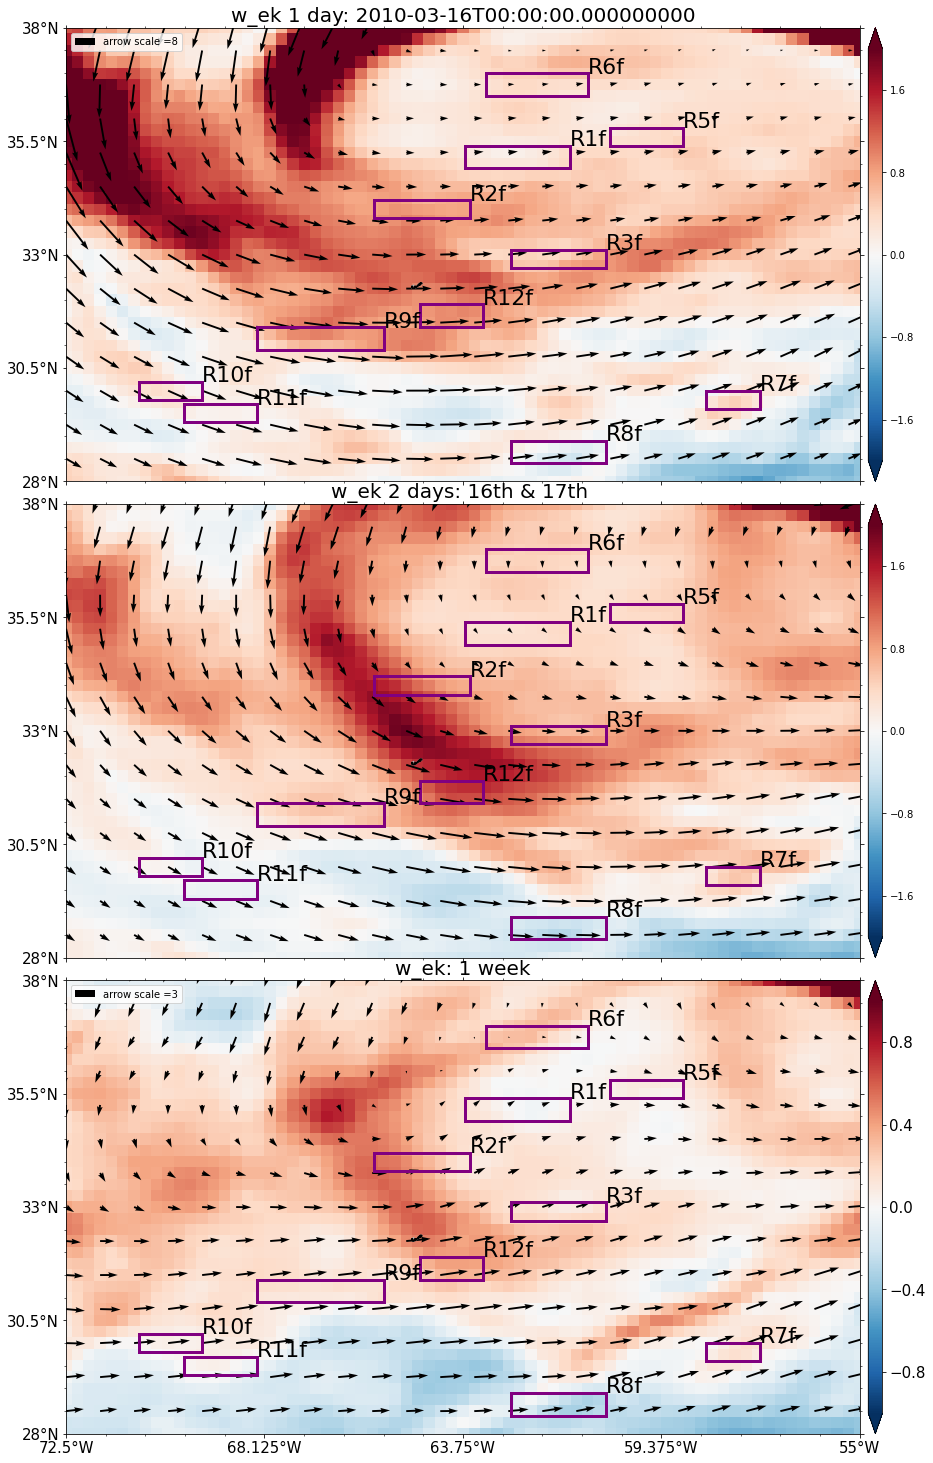

In [68]:
lon = lonw
lat = latw
lon_reg = lon_reg_large = [-72.5, -55]
lat_reg = lat_reg_large = [28, 38]
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
t = 0
hca, hcb = pyic.arrange_axes(1, 3, plot_cb=True, asp=asp, fig_size_fac=4, projection=ccrs_proj, sharex=True, axlab_kw=None)

ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
ar=3
scale = 8
clim= 2
pyic.shade(lon, lat, w_ek_day.isel(time=0).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu_r')
ax.quiver(lonw[::ar], latw[::ar], ustress_day.isel(time=t).var180[::ar,::ar], vstress_day.isel(time=t).var180[::ar,::ar], scale=scale, label=f'arrow scale ={scale}')
add_rectangles()
ax.set_title(f'w_ek 1 day: {ustress_day.time[0].data}', fontsize=20)
ax.legend()

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, w_ek_2d.isel(time=0).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu_r')
ax.quiver(lonw[::ar], latw[::ar], ustress_2d.isel(time=t).var180[::ar,::ar], vstress_2d.isel(time=t).var180[::ar,::ar], scale=scale)
add_rectangles()
ax.set_title(f'w_ek 2 days: 16th & 17th ', fontsize=20)

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 1
pyic.shade(lon, lat, w_ek_week.var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu_r')
scale = 3
ax.quiver(lonw[::ar], latw[::ar], ustress_week.var180[::ar,::ar], vstress_week.var180[::ar,::ar], scale=scale, label=f'arrow scale ={scale}')
add_rectangles()
ax.set_title(f'w_ek: 1 week', fontsize=20)
ax.legend()
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 
    ax.tick_params(labelsize=15)
    cax.tick_params(labelsize=15)

plt.savefig(f'/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/time_dependence/era5_ek_pumping_new fronts_ag22.png', dpi=150, format='png', bbox_inches='tight')


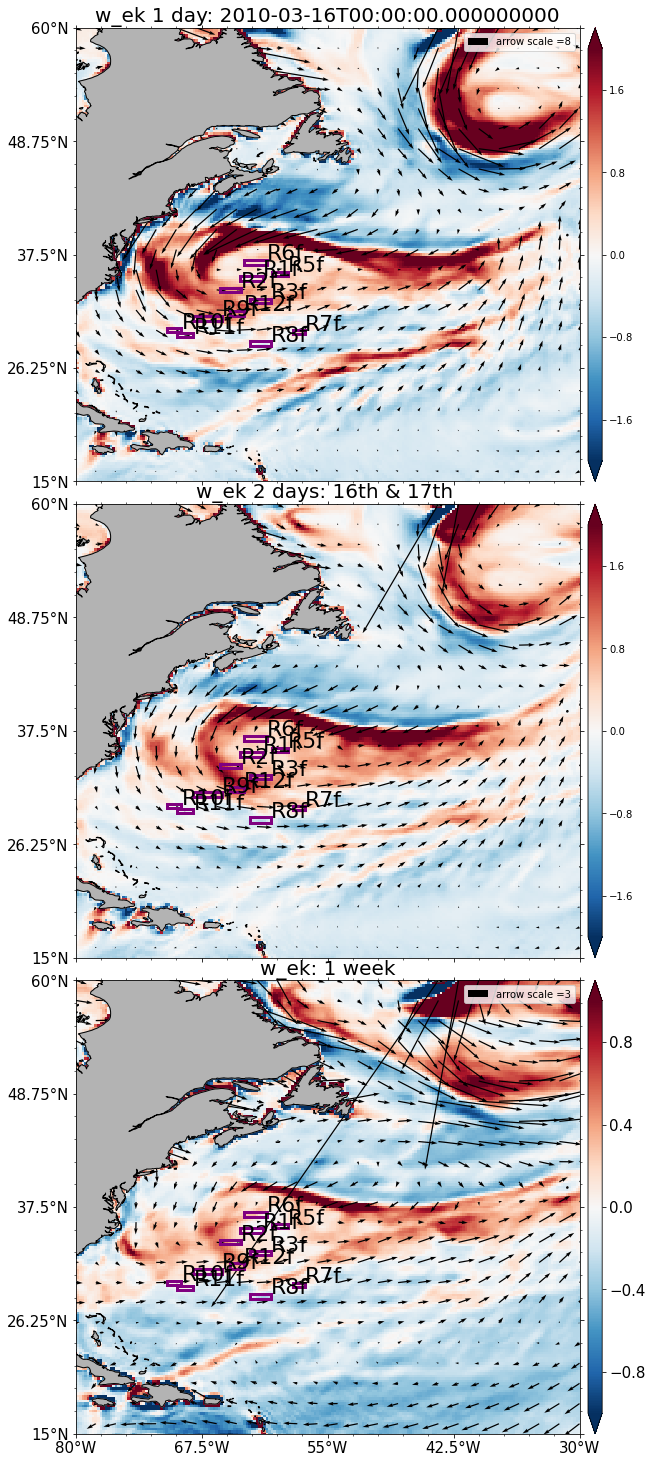

In [76]:
lon = lonw
lat = lat
lon_reg = [-80, -30]
lat_reg = [15, 60]
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
t = 0
hca, hcb = pyic.arrange_axes(1, 3, plot_cb=True, asp=asp, fig_size_fac=4, projection=ccrs_proj, sharex=True, axlab_kw=None)

ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
ar=8
scale = 8
clim= 2
pyic.shade(lon, lat, w_ek_day.isel(time=0).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu_r')
ax.quiver(lonw[::ar], latw[::ar], ustress_day.isel(time=t).var180[::ar,::ar], vstress_day.isel(time=t).var180[::ar,::ar], scale=scale, label=f'arrow scale ={scale}')
add_rectangles()
ax.set_title(f'w_ek 1 day: {ustress_day.time[0].data}', fontsize=20)
ax.legend()

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, w_ek_2d.isel(time=0).var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu_r')
ax.quiver(lonw[::ar], latw[::ar], ustress_2d.isel(time=t).var180[::ar,::ar], vstress_2d.isel(time=t).var180[::ar,::ar], scale=scale)
add_rectangles()
ax.set_title(f'w_ek 2 days: 16th & 17th ', fontsize=20)

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 1
pyic.shade(lon, lat, w_ek_week.var180, ax=ax, cax=cax, clim=clim,  transform=ccrs_proj, rasterized=False, cmap='RdBu_r')
scale = 3
ax.quiver(lonw[::ar], latw[::ar], ustress_week.var180[::ar,::ar], vstress_week.var180[::ar,::ar], scale=scale, label=f'arrow scale ={scale}')
add_rectangles()
ax.set_title(f'w_ek: 1 week', fontsize=20)
ax.legend()
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 
    ax.tick_params(labelsize=15)
    cax.tick_params(labelsize=15)

plt.savefig(f'/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/time_dependence/era5_ek_pumping_new_fronts_large_ag22.png', dpi=150, format='png', bbox_inches='tight')


In [70]:
w_ek_day.lon

<xarray.DataArray 'lon' (lon: 201)>
array([-80.  , -79.75, -79.5 , ..., -30.5 , -30.25, -30.  ])
Coordinates:
  * lon      (lon) float64 -80.0 -79.75 -79.5 -79.25 ... -30.5 -30.25 -30.0

In [73]:
lonw

<xarray.DataArray 'lon' (lon: 201)>
array([-80.  , -79.75, -79.5 , ..., -30.5 , -30.25, -30.  ])
Coordinates:
  * lon      (lon) float64 -80.0 -79.75 -79.5 -79.25 ... -30.5 -30.25 -30.0

In [75]:
latw

<xarray.DataArray 'lat' (lat: 181)>
array([60.  , 59.75, 59.5 , 59.25, 59.  , 58.75, 58.5 , 58.25, 58.  , 57.75,
       57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25, 56.  , 55.75, 55.5 , 55.25,
       55.  , 54.75, 54.5 , 54.25, 54.  , 53.75, 53.5 , 53.25, 53.  , 52.75,
       52.5 , 52.25, 52.  , 51.75, 51.5 , 51.25, 51.  , 50.75, 50.5 , 50.25,
       50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  , 47.75,
       47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25, 46.  , 45.75, 45.5 , 45.25,
       45.  , 44.75, 44.5 , 44.25, 44.  , 43.75, 43.5 , 43.25, 43.  , 42.75,
       42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25, 41.  , 40.75, 40.5 , 40.25,
       40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 , 38.25, 38.  , 37.75,
       37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  , 35.75, 35.5 , 35.25,
       35.  , 34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 , 33.25, 33.  , 32.75,
       32.5 , 32.25, 32.  , 31.75, 31.5 , 31.25, 31.  , 30.75, 30.5 , 30.25,
       30.  , 29.75, 29.5 , 29.25, 29.  , 28.75, 28.5 , 28.25, 28.  , 27.75,
       27.5 , 27.25, 27.  , 26.75, 26.5 , 26.25, 26.  , 25.75, 25.5 , 25.25,
       25.  , 24.75, 24.5 , 24.25, 24.  , 23.75, 23.5 , 23.25, 23.  , 22.75,
       22.5 , 22.25, 22.  , 21.75, 21.5 , 21.25, 21.  , 20.75, 20.5 , 20.25,
       20.  , 19.75, 19.5 , 19.25, 19.  , 18.75, 18.5 , 18.25, 18.  , 17.75,
       17.5 , 17.25, 17.  , 16.75, 16.5 , 16.25, 16.  , 15.75, 15.5 , 15.25,
       15.  ])
Coordinates:
  * lat      (lat) float64 60.0 59.75 59.5 59.25 59.0 ... 15.75 15.5 15.25 15.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y